In [107]:
from skimage import io
import os
from PIL import Image
import pandas as pd

In [108]:
list=os.listdir("train")

In [109]:
import pandas as pd
csv_file = 'HAM10000_metadata.csv'
df=pd.read_csv(csv_file)
df.dx.unique()

# if we only want melanoma or non_melanoma

#df["melanoma"]=pd.get_dummies(df.dx, dtype=float).mel

df_new=df.drop([ "age", "localization", "sex", "dx_type"] , axis=1).copy()

#classes = df_new['dx'].unique()

# Step 2: Create a dictionary mapping classes to numerical labels
#class_to_label = {cls: label for label, cls in enumerate(classes)}

# Step 3: Add a new column to store numerical labels
#df_new['label'] = df_new['dx'].map(class_to_label)

# Check the updated DataFrame
print(df_new['dx'].unique())

classes= df_new['dx'].unique()
for i in classes:
    print('Number of '+str(i)+' = '+str(df_new[df_new['dx']==i].shape[0]))


['bkl' 'nv' 'df' 'mel' 'vasc' 'bcc' 'akiec']
Number of bkl = 1099
Number of nv = 6705
Number of df = 115
Number of mel = 1113
Number of vasc = 142
Number of bcc = 514
Number of akiec = 327


## We just keep the important classes ie., bkl, akiec, bcc, mel and label others as 4.

In [110]:
class_dic={'bkl':0, 'mel':1, 'bcc':2, 'akiec':3, 'others':4}

for i in classes:
    if i in class_dic:
        df_new['label'] = df_new['dx'].map(class_dic)
df_new['label'].fillna(4, inplace=True)

In [111]:
for i in class_dic:
    print('Number of '+str(i)+' = '+str(df_new[df_new['dx']==i].shape[0]))
print('Number of others = '+str(df_new[df_new['dx']=="nv"].shape[0]+df_new[df_new['dx']=="vasc"].shape[0]
      +df_new[df_new['dx']=="df"].shape[0]))


Number of bkl = 1099
Number of mel = 1113
Number of bcc = 514
Number of akiec = 327
Number of others = 0
Number of others = 6962


In [112]:
weights= torch.tensor([])

for key, val in class_dic.items():
     weights = torch.cat((weights, torch.tensor([df_new[df_new['label']==val].shape[0]])), dim=0)
weights

tensor([1099., 1113.,  514.,  327., 6962.])

In [113]:
weights

tensor([1099., 1113.,  514.,  327., 6962.])

In [114]:
df_new[df_new["dx"]=='nv']

,lesion_id,image_id,dx,label
64,HAM_0001751,ISIC_0024698,nv,4.0
1210,HAM_0000559,ISIC_0024693,nv,4.0
2976,HAM_0004932,ISIC_0032212,nv,4.0
2977,HAM_0004516,ISIC_0025775,nv,4.0
2978,HAM_0006510,ISIC_0029828,nv,4.0
...,...,...,...,...
9682,HAM_0006283,ISIC_0027924,nv,4.0
9683,HAM_0000102,ISIC_0031547,nv,4.0
9684,HAM_0000102,ISIC_0032221,nv,4.0
9685,HAM_0005314,ISIC_0030693,nv,4.0


In [115]:
import numpy as np

lesions = df_new['lesion_id'].unique()

train_val_ratio=3
# get the shape from the lesion ids
total_size=lesions.shape[0]
train_size = int(lesions.shape[0]*(train_val_ratio/(train_val_ratio+1)))

np.random.seed(8)
train = np.random.choice(lesions, train_size, replace = False)

#keeping 1 image per lesion id
df_train = df_new[df_new['lesion_id'].isin(train)].sample(frac=1, random_state=0).drop_duplicates(subset=['lesion_id'], keep='first')

df_train.reset_index(drop=True, inplace=True)

df_val = df_new[~df_new['lesion_id'].isin(train)].sample(frac=1, random_state=0).drop_duplicates(subset=['lesion_id'], keep='first')
df_val.reset_index(drop=True, inplace=True)

In [116]:
df_train.shape[0]/df_val.shape[0]

2.998929336188437

In [117]:
train_size
df_small_train=df_train.iloc[:-4000]

## we make a weight tensor to deal with the imbalanced classes in the loss function

In [118]:
weights= torch.tensor([])

for key, val in class_dic.items():
     weights = torch.cat((weights, torch.tensor([train_size/df_train[df_train['label']==val].shape[0]])), dim=0)
weights

tensor([10.1119, 12.5324, 23.1488, 34.7950,  1.3344])

In [119]:
# distribution in the training set
for i in classes:
    print('Percentage of '+str(i)+' = '+str(100*df_train[df_train['dx']==i].shape[0]/train_size))


Percentage of bkl = 9.889325240985363
Percentage of nv = 72.59907176008568
Percentage of df = 1.053195287397358
Percentage of mel = 7.979293109603713
Percentage of vasc = 1.285255265976437
Percentage of bcc = 4.319885755087469
Percentage of akiec = 2.8739735808639773


In [120]:
# distribution in the validation set
for i in classes:
    print('percentage of '+str(i)+' = '+str(100*df_val[df_val['dx']==i].shape[0]/(total_size-train_size)))


percentage of bkl = 9.261241970021413
percentage of nv = 71.5203426124197
percentage of df = 0.7494646680942184
percentage of mel = 8.940042826552462
percentage of vasc = 1.39186295503212
percentage of bcc = 4.550321199143469
percentage of akiec = 3.5867237687366167


In [121]:
df_train.to_csv("./multiclass_train.csv", index=False)
df_small_train.to_csv("./multiclass_small_train.csv", index=False)

df1=pd.read_csv("multiclass_train.csv")

df1

,lesion_id,image_id,dx,label
0,HAM_0004935,ISIC_0031178,nv,4.0
1,HAM_0003071,ISIC_0026000,nv,4.0
2,HAM_0003569,ISIC_0026955,bkl,0.0
3,HAM_0003519,ISIC_0026627,nv,4.0
4,HAM_0001992,ISIC_0025399,nv,4.0
...,...,...,...,...
5597,HAM_0006958,ISIC_0029395,nv,4.0
5598,HAM_0003733,ISIC_0025448,nv,4.0
5599,HAM_0003885,ISIC_0027560,mel,1.0
5600,HAM_0000473,ISIC_0027356,nv,4.0


In [122]:
df1.iloc[:,3]

0       4.0
1       4.0
2       0.0
3       4.0
4       4.0
       ... 
5597    4.0
5598    4.0
5599    1.0
5600    4.0
5601    4.0
Name: label, Length: 5602, dtype: float64

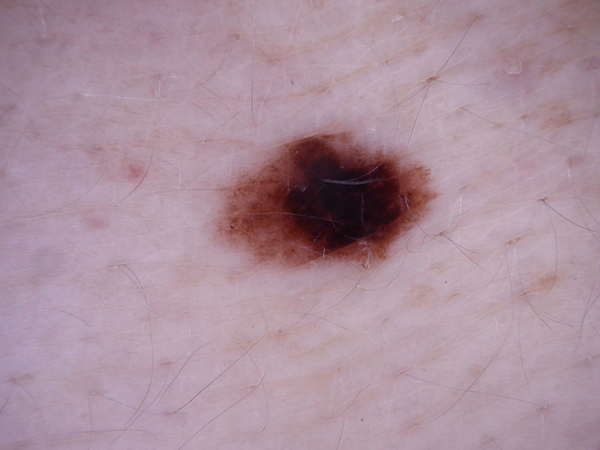

In [123]:
img=Image.open("HAM10000_images_part_1/ISIC_0032600.jpg")

img

In [124]:
import cv2

# Attempt to open the image file using OpenCV
img_cv2 = cv2.imread('HAM10000_images_part_1/ISIC_0032600.jpg')
img_cv2.shape

(450, 600, 3)

In [125]:
import os
from skimage import io
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class customdata(Dataset):
    
    def __init__(self, csv_file, root_dir, transform=None):
        
        self.df=pd.read_csv(csv_file)
        self.root_dir=root_dir
        self.transform=transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        image_name = os.path.join(self.root_dir,  self.df.iloc[idx, 1])
        image = Image.open(image_name+".jpg").convert("RGB")
        label = self.df.iloc[idx, 3]#.long()
    
        if self.transform:
            image = self.transform(image).float()
        
        return image, label


In [126]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms



In [127]:
# Step 1: Prepare the Dataset
transform = transforms.Compose([
    transforms.Resize((400, 400)),
    transforms.CenterCrop(400),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.25, 0.25, 0.25))  # Normalize images
])

csv_file = 'multiclass_train.csv'
root_dir = 'HAM10000_images_part_1/'
custom_dataset = customdata(csv_file=csv_file, root_dir=root_dir, transform=transform)

#test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
#test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)



## Model-1 using pytorch

In [128]:
# Step 2: Define the CNN Architecture
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        # output size = ((w-f+2p)/s)+1 
        
        # input shape (batch size, 3, 400, 400)
        
        self.conv1 = nn.Conv2d(3, 12, kernel_size=3, stride=1, padding=1)
        # output shape (16, 48, 400, 400)
        self.bn1= nn.BatchNorm2d(num_features=12)
        self.relu1=nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2)
        # output shape (16, 48, 200, 200)
        
        self.conv2 = nn.Conv2d(12, 48, kernel_size=3, stride=1, padding=1)
        self.bn2= nn.BatchNorm2d(num_features=48)
        self.relu2=nn.ReLU()
        
        self.conv3 = nn.Conv2d(48, 12, kernel_size=3, stride=1, padding=1)
        # output shape (24, 12, 200, 200)
        self.bn3= nn.BatchNorm2d(num_features=12)
        self.relu3=nn.ReLU()
        

        self.fc = nn.Linear(in_features=12 * 200 * 200, out_features=5)  # 112x150 image size after max pooling
  #      self.fc2 = nn.Linear(128, 2)  # Output 2 classes: cat and dog
        self.sigmoid= nn.Sigmoid()
    
    def forward(self, x):
        output = self.conv1(x)
  #      print(output.shape)
        output = self.bn1(output)
   #     print(output.shape)
        output = self.relu1(output)
    #    print(output.shape)
        output = self.pool(output)
     #   print(output.shape)
        output = self.conv2(output)
        output = self.bn2(output)
        output = self.relu2(output)
      #  print(output.shape)
        output = self.conv3(output)
        output = self.bn3(output)
        output = self.relu3(output)

        output = output.view(-1, 12 * 200 * 200)
        
        output = self.fc(output)
       # print(output)
        output = self.sigmoid(output)
        print(output)
        
        return output

## Model-2 with resnet-18

In [85]:
import torchvision.models as models

class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        
        # Load pre-trained ResNet model
        resnet = models.resnet18(pretrained=True)
        
        # Remove the fully connected layer (classifier) from ResNet
        self.features = nn.Sequential(*list(resnet.children())[:-1])
        
        # Add custom classifier layers
        self.fc1 = nn.Linear(resnet.fc.in_features, 512)
        self.fc2 = nn.Linear(512, num_classes)
        
    def forward(self, x):
        # Extract features using ResNet
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten feature tensor
        
        # Pass through custom classifier layers
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.fc2(x)
        
        return x



In [129]:
# Step 3: Instantiate the Model
model = ConvNet()

# model-2
#num_classes = 5  # Number of classes in your classification task
#model = CustomCNN(num_classes)
# Define the model
#model = torchvision.models.resnet18(weights="ResNet18_Weights.DEFAULT")
#model.fc = torch.nn.Linear(512, 5)


# loading training data

#train_path='./train'
batch_size = 64

# below is if the images were saved in labeled folders
#train_loader=DataLoader(torchvision.datasets.ImageFolder(train_path,transform=transformer),batch_size, shuffle=True)


custom_loader = DataLoader(custom_dataset, batch_size=batch_size, shuffle=True)

#for name, param in model.named_parameters():
 #   if "fc" in name:
  #      param.requires_grad = True
   # else:
    #    param.requires_grad = False

# Step 4: Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = optim.Adam(model.parameters(), lr=0.0001)


device= torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model= model.to(device)

# Step 5: Training Loop
best_accuracy = 0
train_loss= 0
num_epochs=10
for epoch in range(num_epochs):  # Train for 5 epochs
    for i, (images, labels) in enumerate(custom_loader):
        # Forward pass
        optimizer.zero_grad()
        outputs = model(images.to(device))

        #outputs = (outputs > 0.5).float()
        # Compute loss

        labels = labels.to(device).long()
        loss = criterion(outputs, labels)
        print(loss)
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        train_loss += loss.cpu().data*images.size(0)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')




cpu
tensor([[0.5638, 0.3448, 0.3002, 0.3802, 0.4211],
        [0.6001, 0.5021, 0.3329, 0.5670, 0.6029],
        [0.5873, 0.4463, 0.4060, 0.5559, 0.5007],
        [0.5937, 0.4881, 0.3499, 0.4590, 0.5376],
        [0.4533, 0.4696, 0.4060, 0.3984, 0.6427],
        [0.4280, 0.4227, 0.5069, 0.5743, 0.5525],
        [0.5012, 0.3073, 0.3709, 0.3893, 0.5993],
        [0.6392, 0.4041, 0.4004, 0.4500, 0.3613],
        [0.6221, 0.5560, 0.5560, 0.5082, 0.5141],
        [0.5361, 0.3846, 0.3627, 0.3562, 0.6001],
        [0.4989, 0.4403, 0.3419, 0.4044, 0.4184],
        [0.4483, 0.4022, 0.4722, 0.6102, 0.5343],
        [0.5280, 0.4288, 0.4737, 0.4157, 0.4995],
        [0.6230, 0.5975, 0.3682, 0.5863, 0.5767],
        [0.5158, 0.4329, 0.3956, 0.4041, 0.4715],
        [0.5445, 0.4091, 0.3919, 0.4419, 0.5028],
        [0.5404, 0.4485, 0.3603, 0.4078, 0.5268],
        [0.3728, 0.3738, 0.3854, 0.3717, 0.4377],
        [0.5441, 0.4110, 0.4399, 0.4230, 0.5499],
        [0.5648, 0.3696, 0.5720, 0.5346, 0.346

tensor([[3.3023e-02, 3.3842e-12, 9.8190e-11, 1.0000e+00, 6.9021e-09],
        [1.5101e-02, 4.4134e-11, 2.6701e-09, 1.0000e+00, 1.3164e-07],
        [9.8952e-01, 4.9054e-16, 3.1635e-12, 1.0000e+00, 6.3270e-13],
        [6.0429e-01, 7.5031e-12, 5.4758e-10, 1.0000e+00, 1.8903e-05],
        [9.3624e-06, 3.8491e-20, 2.3653e-21, 1.0000e+00, 1.2318e-15],
        [1.0000e+00, 2.3823e-20, 2.3938e-06, 1.0000e+00, 1.0799e-17],
        [6.4124e-01, 2.3354e-12, 7.0276e-08, 1.0000e+00, 2.9932e-09],
        [3.0924e-01, 7.1154e-13, 2.7753e-14, 1.0000e+00, 2.2077e-08],
        [3.8526e-01, 1.8810e-10, 5.4026e-09, 1.0000e+00, 3.3041e-08],
        [9.6808e-01, 7.6254e-13, 4.3852e-08, 1.0000e+00, 2.6734e-12],
        [3.7469e-01, 3.7459e-10, 7.0116e-09, 1.0000e+00, 4.0605e-11],
        [8.5433e-02, 4.8863e-16, 2.7082e-18, 1.0000e+00, 8.2370e-11],
        [9.9704e-01, 2.5975e-15, 1.8276e-11, 1.0000e+00, 3.6990e-11],
        [8.1014e-01, 1.7530e-09, 3.4705e-10, 1.0000e+00, 1.0595e-07],
        [7.0069e-02,

KeyboardInterrupt: 

## Validation data loader

In [20]:
df_val.to_csv("./multiclass_val.csv", index=False)

df1=pd.read_csv("multiclass_val.csv")

df1

,lesion_id,image_id,dx,label
0,HAM_0003072,ISIC_0032611,bcc,3.0
1,HAM_0003657,ISIC_0026740,nv,2.0
2,HAM_0003985,ISIC_0025570,nv,2.0
3,HAM_0000233,ISIC_0028219,mel,1.0
4,HAM_0006628,ISIC_0033111,nv,2.0
...,...,...,...,...
1863,HAM_0003496,ISIC_0027308,nv,2.0
1864,HAM_0002744,ISIC_0031236,bcc,3.0
1865,HAM_0005453,ISIC_0027022,nv,2.0
1866,HAM_0005072,ISIC_0031632,nv,2.0


In [ ]:
csv_file = 'multiclass_val.csv'
root_dir = 'HAM10000_images_part_1/'
custom_dataset_val = customdata(csv_file=csv_file, root_dir=root_dir, transform=transform)

#test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
val_loader = torch.utils.data.DataLoader(custom_dataset_val, batch_size=32, shuffle=False)



In [ ]:
# Step 6: Evaluation
correct = 0
total = 0
with torch.no_grad():
    for data in val_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct / total}%')


In [214]:
df_train.dx.unique()

array(['nv', 'bkl', 'mel', 'vasc', 'bcc', 'akiec', 'df'], dtype=object)

In [45]:
grid=['a0vc','cvbn']
grid[0][1]

'0'

In [257]:
df

,lesion_id,image_id,dx,dx_type,age,sex,localization,melanoma
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,0.0
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,0.0
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,0.0
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,0.0
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,0.0
...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,0.0
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,0.0
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,0.0
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,0.0
